# LAB 5. Hypothesis Testing: Green Taxi Case.


Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2019-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import urllib.request
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Upload data
dfTaxi = pd.read_csv('https://data.cityofnewyork.us/api/views/pkmi-4kfn/rows.csv?accessType=DOWNLOAD')
dfTaxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,12/18/2019 03:52:30 PM,12/18/2019 03:54:39 PM,N,1.0,264,264,5.0,0.00,3.5,0.50,0.5,0.01,0.0,NaN,0.3,4.81,1.0,1.0,0.00
1,2.0,01/01/2020 12:45:58 AM,01/01/2020 12:56:39 AM,N,5.0,66,65,2.0,1.28,20.0,0.00,0.0,4.06,0.0,NaN,0.3,24.36,1.0,2.0,0.00
2,2.0,01/01/2020 12:41:38 AM,01/01/2020 12:52:49 AM,N,1.0,181,228,1.0,2.47,10.5,0.50,0.5,3.54,0.0,NaN,0.3,15.34,1.0,1.0,0.00
3,1.0,01/01/2020 12:52:46 AM,01/01/2020 01:14:21 AM,N,1.0,129,263,2.0,6.30,21.0,3.25,0.5,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75
4,1.0,01/01/2020 12:19:57 AM,01/01/2020 12:30:56 AM,N,1.0,210,150,1.0,2.30,10.0,0.50,0.5,0.00,0.0,NaN,0.3,11.30,1.0,1.0,0.00


In [3]:
#Take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [4]:
#Extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2019, 2020])]

In [5]:
#Calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [6]:
#Calculate average trip speed (MPH)
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60)

In [7]:
#Original number of records
len(dfTaxi)

1734017

In [8]:
#Sanity filtering
dfTaxi = dfTaxi[(dfTaxi.trip_distance < 100)& (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1) & (dfTaxi.Year == 2020)]
len(dfTaxi) #remaining records

1644906

In [9]:
#Daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()

dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

#Calculate average speed
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
8,2020,1,2,2020-01-01,10387,146492.633333,42765.71,17.515847
13,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824
18,2020,1,4,2020-01-03,15461,251978.733333,62161.70,14.801654
23,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933
27,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858


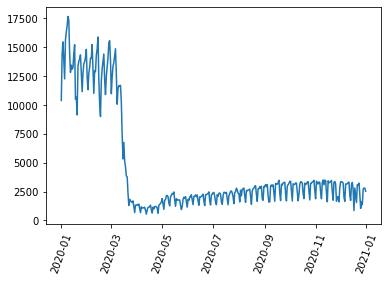

In [10]:
#Ridership timeline - daily trip counts
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

## Example: Test if weekend ridership is different from weekday

In [11]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# t-test
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['DOW']>4]['trip_count'],
                dfTaxiDaily.loc[dfTaxiDaily['DOW']<4]['trip_count'])

Ttest_indResult(statistic=-1.8696377164195723, pvalue=0.06247062244346498)

In [12]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# KS-test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['DOW']>4]['trip_count'],
                dfTaxiDaily.loc[dfTaxiDaily['DOW']<4]['trip_count'])

KstestResult(statistic=0.4074175824175824, pvalue=6.401479346607175e-11)

## Research questions to further explore
- Which weekdays are similar/different in terms of avg.travel speed distributions?
- Are evening/morning/afternoon trip speed, duration and distance distributions signifiantly different?
- Are trip speed, duration and distance distributions different in Brooklyn vs Queens or Bronx? 
- No doubt that 2020 saw a large drop in ridership but how can we assess it? As we don't have the full year, the drop just started in March and there is also a general decline, consider the 2020/2019 ratios (to account for the general trend and seasonality and see how much more steep is the drop during the pandemics). Compare the pandemics numbers (After March 2020 with the same period pre-march 2020). Also compare the post-pandemics and pre-pandemics travel distance, speed and duration distributions